<div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 40px; margin-top: 0;">
    <div style="flex: 0 0 auto; margin-left: 0; margin-bottom: 0; margin-top: 0;">
        <img src="./pics/UCSD Logo.png" alt="UCSD Logo" style="width: 179px; margin-bottom: 0px; margin-top: 20px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/LANL-logo.png" alt="LANL Logo" style="width: 200px; margin-bottom: 0px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/prowess.png" alt="Prowess Logo" style="width: 200px; margin-bottom: 0px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/wildfire.png" alt="WildFire Logo" width="100"/>
    </div>
</div>

<h1 style="text-align: center; font-size: 48px; margin-top: 0;">Fire-Ready Forests Data Challenge</h1>

# FastFuels

This notebook describes FastFuels and how it works as well as how the FastFuels data were generated for the data challenge. 

For the data challenge, there is no need to run this notebook, it is for demonstration purposes, since we have already registered this dataset in the Data Catalog.

In case you want to run this notebook, you will need a Fast Fuels API key, which you can request here: https://fastfuels.silvxlabs.com/

For more information on FastFuels, you can look at the source code [here](https://github.com/silvxlabs/fastfuels-core/blob/main/fastfuels_core/point_process.py) and read the mathematical formulation in the [FastFuels paper](https://www.sciencedirect.com/science/article/pii/S1364815224002755)

In [ ]:
import json 
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import geojson
import time
import matplotlib.pyplot as plt

In [ ]:
apikey = input("FastFuels API Key:#YOUR-API-KEY")

[FastFuels](https://www.firelab.org/project/fastfuels-3d-fuels-next-generation-fire-models) is a 3D model of vegetation used primarily for the use in 3D fire models. FastFuels leverages multiple data sources including the [Treemap](https://data.fs.usda.gov/geodata/rastergateway/treemap/index.php) project run by the United States Forest Service (USFS). Throughout the US, the USFS has run the [Forest Inventory and Analysis (FIA) program](https://research.fs.usda.gov/programs/fia), which is a historic data collection program where they have sampled representative land cover and land use types throughout the US, collecting data about forest resources, health, and ownership consistently over time. The Treemap project is a model that has assigned a representative FIA plot for each 30 m<sup>2</sup> area of the contiguous US. FastFuels is able to use the outputs of Treemap to simulate what trees might be found in any given location.

We should take the plots identification csv file and use this to define the area where we will be generating FastFuels treelists from. The surveyed area will represent tenth acre plots. The plots identification csv file only gives information about the plot center, so we will be using the geopandas library to help us create polygons from the points.

In [ ]:
plots_df = pd.read_csv('https://wifire-data.sdsc.edu/data/ndp/Data_challenge_2024/new_data/field_data/01_plot_identification.csv') # This is the Plot Identification file from the Field Data dataset

plots_df.head()

,inventory_id,site_project,site_project_label,site_name,site_name_label,inventory_pre_post_fire,inventory_pre_post_fire_label,plot_num,plot_blk,inventory_date,...,groundpost_cover_total,veg_cover_id,veg_cover_tot_veg_percent,veg_cover_tov_percent,veg_cover_und_percent,veg_cover_tos_percent,veg_cover_herb_percent,sp_invcov_id,sp_cov_inv_obs,sp_cov_inv_obs_label
0,143_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,143,CAFKU_0143_20240721_1,7/21/24,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
1,140_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,140,CAFKU_0140_20240721_1,7/21/24,...,100,1,95.0,15.0,2.0,5.0,80.0,1,3.0,Abigail
2,152_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,152,CAFKU_0152_20240721_1,7/21/24,...,100,1,55.0,30.0,5.0,0.0,20.0,1,3.0,Abigail
3,147_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,147,CAFKU_0147_20240720_1,7/20/24,...,100,1,75.0,30.0,15.0,8.0,25.0,1,3.0,Abigail
4,151_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,151,CAFKU_0151_20240720_1,7/20/24,...,100,1,75.0,50.0,5.0,2.0,40.0,1,3.0,Abigail


In the plots identification file, the columns `plot_coord_x`, `plot_coord_y`, and `plot_coord_srs` are the most relevant for creating polygons. `plot_coord_srs` is the spatial reference system in [UTM (Universal Transverse Mercator) zones](https://www.usgs.gov/faqs/what-does-term-utm-mean-utm-better-or-more-accurate-latitudelongitude). Because California is so large, there are two UTM zones in this dataset, so we will need to clean up the dataset a bit.

In [4]:
print(f'The UTM zones are: {np.unique(plots_df.plot_coord_srs)}')

The UTM zones are: [26910 26911]


Fast Fuels actually uses the [EPSG:5070](https://epsg.io/5070-1252) projection, which is valid for the contiguous US, so we will be projecting the data to EPSG:5070 projection.

In [5]:
plots_intermediate = []
for srs in np.unique(plots_df.plot_coord_srs):
    plots_subset = plots_df[plots_df.plot_coord_srs == srs]
    plots_subset_gdf = gpd.GeoDataFrame(plots_subset, 
                                   geometry = gpd.points_from_xy(plots_subset.plot_coord_x, plots_subset.plot_coord_y), 
                                   crs = srs)

    #reproject to EPSG 5070
    plots_subset_gdf = plots_subset_gdf.to_crs(5070)
    
    plots_intermediate.append(plots_subset_gdf)

plots_gdf = pd.concat(plots_intermediate)
plots_gdf = plots_gdf.dropna(subset = 'plot_blk')

Check out the geometry column - they are points

In [6]:
plots_gdf.head().geometry

16    POINT (-2049255.536 2089359.998)
17    POINT (-2048644.910 2089443.267)
18    POINT (-2048714.646 2089627.893)
19    POINT (-2048476.130 2089526.135)
21    POINT (-2048375.533 2089348.205)
Name: geometry, dtype: geometry

In [7]:
#buffer the plots to get 1/10 acre plots
plot_size = 1/10 #acre
acre_to_m2 = 4046.86
plot_size_m2 = plot_size * acre_to_m2
plot_radius = np.sqrt(plot_size_m2/np.pi)

plots_gdf = plots_gdf.set_geometry(plots_gdf.buffer(plot_radius))

Check out the geometry column again - now it is a polygon

In [8]:
plots_gdf.head().geometry

16    POLYGON ((-2049244.186 2089359.998, -2049244.2...
17    POLYGON ((-2048633.560 2089443.267, -2048633.6...
18    POLYGON ((-2048703.297 2089627.893, -2048703.3...
19    POLYGON ((-2048464.781 2089526.135, -2048464.8...
21    POLYGON ((-2048364.183 2089348.205, -2048364.2...
Name: geometry, dtype: geometry

Now that we have the data in the correct format, we can now use the [Fast Fuels API](https://api.fastfuels.silvxlabs.com/redoc) to generate treelists

In [9]:
def wait_for_complete(request_url, headers):
    '''
    wait for the response to be completed
    request_url is the url to be requested
    headers is the headers
    '''
    response = json.loads(requests.get(url = request_url, headers = headers).text)
    while response['status'] in ('pending', 'processing', 'running' ):
        time.sleep(5)
        response = json.loads(requests.get(url = request_url, headers = headers).text)


def get_treelist(site, apikey, gjson, plot_name, temp_file):

    '''
    get the treelist from fast fuel API
    creates the domain, does road and water masks, creates the tree inventories
    downloads the inventory
    returns the tree list
    site is 'https://api.fastfuels.silvxlabs.com/v1/domains'
    apikey is the api key
    plot_name is the name of the plot
    temp_file is the location to temporary save the file (.geojson)
    '''
    
    gjson['name'] = plot_name
    gjson['description'] = f'This is for {plot_name}'
    gjson['horizontalResolution'] = 2
    gjson['verticalResolution'] = 1
    
    headers = {'accept': 'application/json',
             'api-key': apikey,
        'Content-Type': 'application/json',
    }
    
    #create domain
    domain_response = requests.post(site, headers = headers, json = gjson)
    domain_id = json.loads(domain_response.text)['id']
    
    
    #create road mask
    json_data_road_water = {
        'sources': [
            'OSM',
        ],
    }
    
    road_response = requests.post(f'{site}/{domain_id}/features/road', headers = headers, 
                  json = json_data_road_water)
    
    #create water mask
    water_response = requests.post(f'{site}/{domain_id}/features/water', headers = headers, 
                  json = json_data_road_water)
    
    #wait until water and road mask response completed
    wait_for_complete(f'{site}/{domain_id}/features/road', headers)
    wait_for_complete(f'{site}/{domain_id}/features/water', headers)
    
    
    #create tree inventory resource
    json_data_tree = {
        'sources': [
            'TreeMap',
        ]
    }
    
    tree_inventory_response = requests.post(f'{site}/{domain_id}/inventories/tree', headers = headers, 
                  json = json_data_tree)
    
    #wait until tree inventory response completed
    wait_for_complete(f'{site}/{domain_id}/inventories/tree', headers)
    
    #create tree grid
    json_data_tree_grid = {
        'attributes': [
            'bulkDensity',
            'fuelMoisture',
        ],
        'fuelMoisture': {
            'source': 'uniform',
            'value': 125,
        },
    }
    
    
    tree_grid_response = requests.post(f'{site}/{domain_id}/grids/tree', headers = headers, 
                  json = json_data_tree_grid)
    
    #wait until tree grid inventory response completed
    wait_for_complete(f'{site}/{domain_id}/grids/tree', headers)
    
    #get tree inventory
    tree_inventory = requests.post(f'{site}/{domain_id}/inventories/tree/exports/geojson', headers = headers)
    
    #wait until tree grid inventory response completed
    wait_for_complete(f'{site}/{domain_id}/inventories/tree/exports/geojson', headers)
    
    inventory_response = json.loads(requests.get(f'{site}/{domain_id}/inventories/tree/exports/geojson', headers = headers).text)
    inventory_status = inventory_response['status']
    
    if inventory_status == 'completed':
        download_link = inventory_response['signedUrl']
        wget.download(download_link, temp_file)
        tree_list = gpd.read_file(temp_file)
        tree_list['plot_name'] = plot_name
        return(tree_list)
    
    else:
        print('fail')

here's what the spatial data look like


In [10]:
geojson.loads(plots_gdf.iloc[[0]].to_json())

{"crs": {"properties": {"name": "urn:ogc:def:crs:EPSG::5070"}, "type": "name"}, "features": [{"geometry": {"coordinates": [[[-2049244.185938, 2089359.998217], [-2049244.24059, 2089358.885752], [-2049244.404019, 2089357.784001], [-2049244.674652, 2089356.703575], [-2049245.049882, 2089355.654877], [-2049245.526095, 2089354.648008], [-2049246.098706, 2089353.692665], [-2049246.7622, 2089352.798047], [-2049247.510186, 2089351.972771], [-2049248.335462, 2089351.224785], [-2049249.23008, 2089350.561291], [-2049250.185423, 2089349.98868], [-2049251.192292, 2089349.512467], [-2049252.24099, 2089349.137237], [-2049253.321417, 2089348.866604], [-2049254.423167, 2089348.703175], [-2049255.535632, 2089348.648523], [-2049256.648097, 2089348.703175], [-2049257.749847, 2089348.866604], [-2049258.830274, 2089349.137237], [-2049259.878972, 2089349.512467], [-2049260.885841, 2089349.98868], [-2049261.841184, 2089350.561291], [-2049262.735802, 2089351.224785], [-2049263.561078, 2089351.972771], [-204926

In [11]:
#the following goes through each plot and generates the fast fuels treelist for each
nrows, ncols = plots_gdf.shape
site = 'https://api.fastfuels.silvxlabs.com/v1/domains'
temp_file = 'temp_file.geojson'

fftl_df_list = []

for i in np.arange(nrows):
    gjson = geojson.loads(plots_gdf.iloc[[i]].to_json())
    plot_name = plots_gdf.iloc[[i]].plot_blk.values[0]
    
    fftl_df_list.append(get_treelist(site, apikey, gjson, str(plot_name), temp_file))

#make the final fast fuel treelist
final_fftl = pd.concat(fftl_df_list)

#save treelist
final_fftl.to_csv('full_fftl_plots.csv')

100% [..............................................................] 3319 / 3319

fast fuels generates the treelist in a rectangle around the plot (which is circular), so we can perform a spatial join operation to get only the trees in the plot. Note that some plots may have trees that are all already be contained in the circular plot boundary.


In [12]:
# fast fuels returns the treelist in EPSG:5070

ff_gpd = gpd.GeoDataFrame(final_fftl, geometry = gpd.points_from_xy(final_fftl.X, final_fftl.Y), crs = 5070)

print(ff_gpd.shape)
ff_gpd.head()

(204, 14)


,CHUNK_ID,TREE_ID,PLOT_ID,SPCD,STATUSCD,DIA,HT,CR,X,Y,ROW_CHUNK,COL_CHUNK,geometry,plot_name
0,0_0,1488583,55336,108,1,3.810,2.7432,0.66,-2.049254e+06,2.089367e+06,0,0,POINT (-2049253.581 2089367.176),CATNF_6053_20240817_1
1,0_0,1488596,55336,108,1,5.842,3.9624,0.73,-2.049265e+06,2.089362e+06,0,0,POINT (-2049265.399 2089361.786),CATNF_6053_20240817_1
2,0_0,1488584,55336,108,1,3.302,2.4384,0.66,-2.049256e+06,2.089371e+06,0,0,POINT (-2049255.659 2089371.454),CATNF_6053_20240817_1
3,0_0,1488580,55336,108,1,3.048,2.7432,0.70,-2.049260e+06,2.089363e+06,0,0,POINT (-2049259.808 2089362.973),CATNF_6053_20240817_1
4,0_0,1488578,55336,108,1,2.794,2.4384,0.60,-2.049264e+06,2.089371e+06,0,0,POINT (-2049263.826 2089371.093),CATNF_6053_20240817_1


Text(107.22933052495726, 0.5, 'Y (meters)')

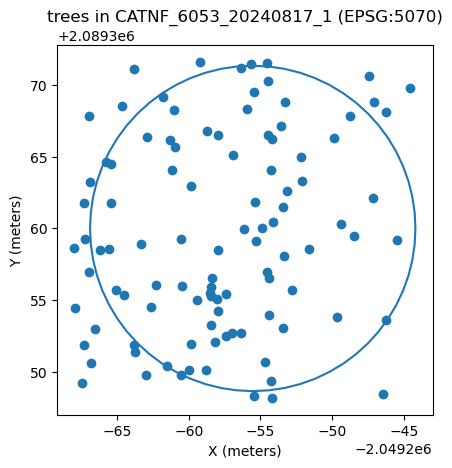

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
randomly_chosen_plot = 40
plot_of_interest = ff_gpd.plot_name.values[randomly_chosen_plot]

ff_gpd[ff_gpd.plot_name == plot_of_interest].plot(ax = ax)
plots_gdf[plots_gdf.plot_blk == plot_of_interest].boundary.plot(ax = ax)
plt.title('trees in ' + plot_of_interest +  ' (EPSG:5070)')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

In [14]:
# peform the spatial join - this will get only the trees that are within the circular plot boundaries
ff_csv = ff_gpd.sjoin(plots_gdf)
ff_csv.shape

(150, 76)

Text(107.22933052495726, 0.5, 'Y (meters)')

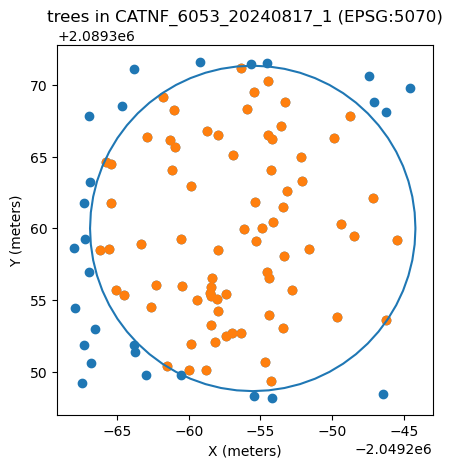

In [15]:
fig, ax = plt.subplots()
ff_gpd[ff_gpd.plot_name == plot_of_interest].plot(ax = ax, label = 'trees removed')
ff_csv[ff_csv.plot_name == plot_of_interest].plot(ax = ax, label = 'trees kept')
plots_gdf[plots_gdf.plot_blk == plot_of_interest].boundary.plot(ax = ax)
plt.title('trees in ' + plot_of_interest +  ' (EPSG:5070)')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

In [ ]:
#save as csv - this csv is provided for you in the data challenge
ff_csv[['SPCD', 'DIA', 'HT', 'STATUSCD', 
       'CR', 'X', 'Y', 'plot_name', 'geometry']].to_csv('fftl_plots.csv')

### Acknowledgment

This Jupyter Notebook utilizes core code developed by Leticia Lee from the San Diego Supercomputer Center. The content, including analysis and visualizations, builds upon Leticia's foundational work, and we appreciate his contribution to the underlying codebase. Proper credit is appreciated if this notebook is shared or adapted for further use.